In [35]:
import matplotlib.pyplot as plt
import numpy as np

In [36]:
# Parameters
sampling_rate = 4000
effective_tunnels = (6, )

In [218]:
# Load Sensor-output Data
displacement = np.loadtxt('data/B1-2-4.txt', skiprows=1, usecols=effective_tunnels)
print(displacement[0:10])

[677.101563 687.058411 689.292786 693.016785 697.603149 699.719971
 705.71759  708.775208 711.63678  716.301575]


In [219]:
# time_axis = np.arange(0, displacement.shape[0])
time_axis = np.arange(5000, 5400)
time_axis = time_axis / sampling_rate

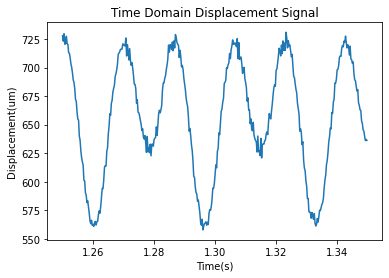

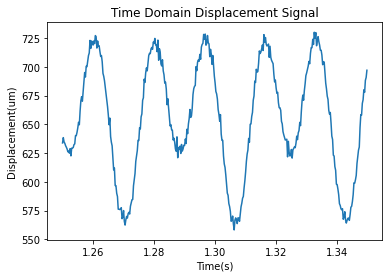

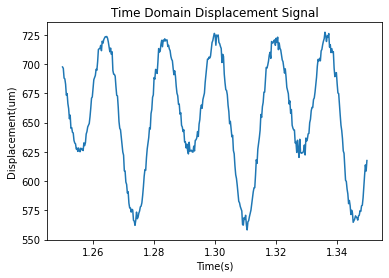

In [220]:
# Time Domain Signal Diagram
def time_domain_disp_plotting(disp):
    plt.figure()

    plt.plot(time_axis, disp)
    plt.title(u'Time Domain Displacement Signal')
    plt.xlabel('Time(s)')
    plt.ylabel('Displacement(um)')

    plt.show()
    
time_domain_disp_plotting(displacement[5000:5400])
time_domain_disp_plotting(displacement[8000:8400])
time_domain_disp_plotting(displacement[9000:9400])

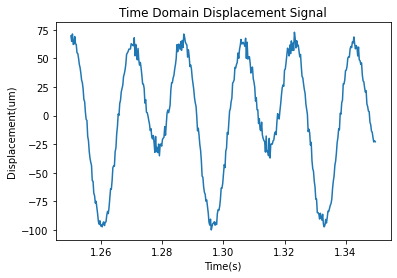

In [221]:
# Filter
from scipy import signal

def highpass_filtering(x, freq_low, fs, order=2):
    sos = signal.butter(order, freq_low, fs=fs, btype='highpass', output='sos')
    y = signal.sosfiltfilt(sos, x)
    return y

displacement = highpass_filtering(displacement, 10, sampling_rate, order=4)

time_domain_disp_plotting(displacement[5000:5400])

In [211]:
# FFT
import scipy.fftpack as fftpack

displayed_max_freq = 200
assert displayed_max_freq > 0 and displayed_max_freq < (sampling_rate // 2)

freq_spectrum = fftpack.fft(displacement)

freq_axis = fftpack.fftfreq(displacement.size, d=1/sampling_rate)
# freq_axis = fftpack.fftshift(freq_axis)
print(freq_axis[0:10])

freq_spectrum_magnitude = np.sqrt(np.real(freq_spectrum)**2 + np.imag(freq_spectrum)**2)

[0.         0.06991785 0.13983569 0.20975354 0.27967139 0.34958923
 0.41950708 0.48942493 0.55934277 0.62926062]


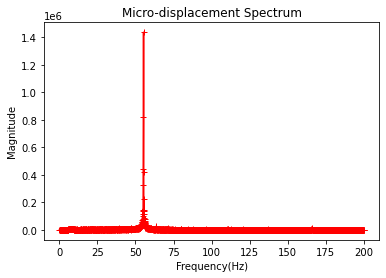

In [212]:
# Spetrum Plotting
plt.figure()

sampling_num = displacement.size * displayed_max_freq // sampling_rate
plt.plot(freq_axis[1:sampling_num], freq_spectrum_magnitude[1:sampling_num], 'r+-')
plt.title(u'Micro-displacement Spectrum')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Magnitude')

plt.show()

In [213]:
# Measurement Results
dominant_freq = freq_axis[np.argmax(freq_spectrum_magnitude[1:])]
print('Dominant Frequency(Hz): %.2f' % dominant_freq)

Dominant Frequency(Hz): 55.24


## Similarity Analysis

In [214]:
import warnings
from scipy.optimize import curve_fit, OptimizeWarning


def sine_func(t, a, f, p):
    return a * np.sin(2 * np.pi * f * t + p)

def _fit_sine_simple(t, x, param_init):
    param_est = curve_fit(sine_func, t, x, p0=param_init)[0]
    return param_est

def fit_sine(t, x, param_init=None, mode="Simple", return_fitted=False):
    if param_init is None:
        a = 1
        f = 100
        p = 0
        param_init = np.array([a, f, p])
    if mode == "Simple":
        with warnings.catch_warnings():
            warnings.simplefilter("error", OptimizeWarning)
            try:
                param_est = _fit_sine_simple(t, x, param_init)
            except RuntimeError:
                param_est = param_init
            except OptimizeWarning:
                param_est = param_init
    else:
        assert False, "Bug Error!!"
        param_est = _fit_sine_robust(t, x, param_init)

    # print(f"init param = {param_init}, est param = {param_est}")

    if not return_fitted:
        return param_est
    else:
        return param_est, sine_func(t, param_est[0], param_est[1], param_est[2])

In [215]:
# Sinusoidal Signal Fitting
def analyze_vib_signal(vib_signal, slow_time_sample_rate, return_fitted=False):
    lx = vib_signal.shape[0]

    vib_freq = np.fft.fft(vib_signal)
    vib_freq_amps = np.abs(vib_freq)
    freq_bins = (slow_time_sample_rate / lx) * np.arange(0, lx)
    max_idx = np.argmax(vib_freq_amps[0:lx // 2])
    freq = freq_bins[max_idx]
    phase = np.angle(vib_freq[max_idx])
    amp = (np.max(vib_signal) - np.min(vib_signal)) / 2

    ts = 1 / slow_time_sample_rate * np.arange(0, lx)

    if return_fitted:
        (amp, freq, phase), fitted_signal = fit_sine(
            ts, vib_signal,
            param_init=np.array([amp, freq, phase]),
            mode="Simple", return_fitted=return_fitted)

        return amp, freq, phase, freq_bins, vib_freq_amps, fitted_signal
    else:
        amp, freq, phase = fit_sine(ts, vib_signal, param_init=np.array([amp, freq, phase]), mode="Simple", return_fitted=return_fitted)
        return amp, freq, phase

In [216]:
amp, freq, _ = analyze_vib_signal(displacement, sampling_rate)
print('Amplitude: %.2fum' % amp)
print('Frequency: %.2fHz' % freq)

Amplitude: 63.51um
Frequency: 55.28Hz


In [222]:
amp, freq, _ = analyze_vib_signal(displacement[5000:5400], sampling_rate)
print('Amplitude: %.2fum' % amp)
print('Frequency: %.2fHz' % freq)
amp, freq, _ = analyze_vib_signal(displacement[8000:8400], sampling_rate)
print('Amplitude: %.2fum' % amp)
print('Frequency: %.2fHz' % freq)
amp, freq, _ = analyze_vib_signal(displacement[9000:9400], sampling_rate)
print('Amplitude: %.2fum' % amp)
print('Frequency: %.2fHz' % freq)

Amplitude: 65.23um
Frequency: 54.75Hz
Amplitude: 63.39um
Frequency: 54.90Hz
Amplitude: 63.10um
Frequency: 55.32Hz
